# Decoding Mouse Visual Cortex
We will try to decode mouse brain to understand which image animal is straing at. Stringer and Colleques imaged visual cortex of mouse with two-photon microscopy. In the dataset we will analyze animal looks at images coming from 32 categories and blank, total 33 categories for us to decode. 
Question is can we learn which image animal is looking at from neuron activities in the brain using common algorithms and methods in ML

https://www.nature.com/articles/s41586-019-1346-5

Lets laod the data first

In [3]:
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
sns.set(style='white')

In [88]:
%matplotlib notebook

In [5]:
%matplotlib inline

In [6]:
Xdf = pd.read_csv('natimg32_M170717_MP033_2017-08-25_stim_resp', header=None)

In [7]:
labels = pd.read_csv('natimg32_M170717_MP033_2017-08-25_labels', header=None)

In [9]:
Y = np.array(labels) #making numpy array
Y=Y-1; Y=Y.reshape(Y.shape[0],)
print('data shape: ', Xdf.shape) #3168 samples - 11523 neurons
print('labels: ', Y.shape)

data shape:  (3168, 11523)
labels:  (3168,)


In [11]:
X = np.array(Xdf)

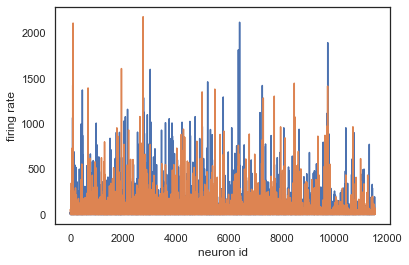

In [15]:
#Neural Firing for two images
plt.plot(X[0,:])
plt.plot(X[1,:])
plt.xlabel('neuron id')
plt.ylabel('firing rate')
plt.show()

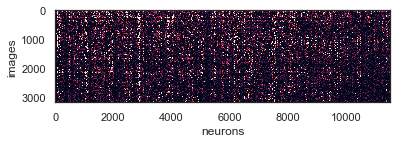

In [16]:
# Firing Rate heatmap
plt.imshow(X,vmin=0, vmax=100)
plt.xlabel('neurons')
plt.ylabel('images')
plt.show()

### Explore the data

Average # of Neurons fired for an image: 5128.0


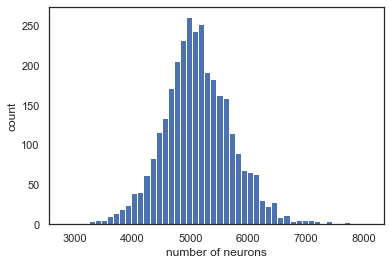

In [17]:
#Q: How many neurons fires on average to an image?
#A: ~5000 neurons so almost half of the neurons recorded.
print('Average # of Neurons fired for an image:',np.count_nonzero(X,axis=1).mean().round()) 

#Q: Distirbution of the number of neurons firing for each image
#A: Changes from 3000 to 8000 neurons
plt.hist(np.count_nonzero(X,axis=1),50)
plt.xlabel('number of neurons')
plt.ylabel('count')
plt.show()

Average # of images fired for a neuron: 1410.0


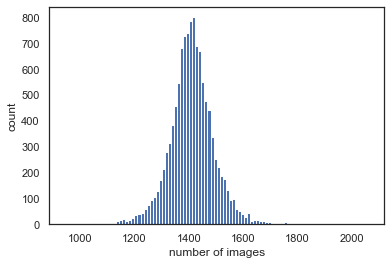

In [18]:
#Q: How many images does each neuron fires on average?
#A: ~1400 neurons so almost half of the images.
print('Average # of images fired for a neuron:',np.count_nonzero(X,axis=0).mean().round()) 

#Q: Distirbution of the number of images for each neuron
#A: Changes from 1000 to 1800 neurons
plt.hist(np.count_nonzero(X,axis=0),100) # For how to choose number of bins in a histogram please check out... 
#my tutorial here: [insert link]
plt.xlabel('number of images')
plt.ylabel('count')
plt.show()

It's not that sparse matrix given the numbers that we got above.

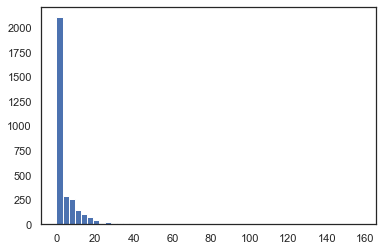

1413


In [19]:
plt.hist(X[:,0],50) #Neuron 0 firing rates for all samples
plt.show()
print(np.count_nonzero(X[:,0]))

Let's do log tranformation of the data before doing any normalization. This is not log-normal distribution it's negative binomial. It is not the best idea to assume log transform makes it normal for z-score. However, for our purpose for now it's ok.

In [20]:
X_log = np.log2(X+1) #Base 2 is an arbitrary choice

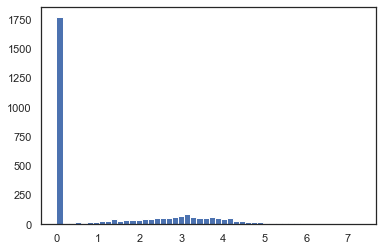

In [21]:
plt.hist(X_log[:,0],50) #Neuron 0 firing rates for all samples
plt.show()

Standardize the data: $\frac{X-\mu(X)}{\sigma(X)}$

In [22]:
X_norm = ( X_log - np.mean(X_log,axis=0) ) / np.std(X_log,axis=0)
X_norm.shape

(3168, 11523)

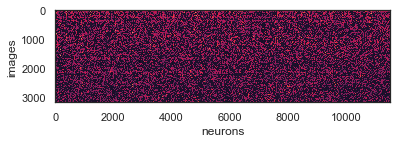

In [23]:
#Visualize the data again
plt.imshow(X_norm)
plt.xlabel('neurons')
plt.ylabel('images')
plt.show()

## Dimensionality Reduction - Visualize the data in low-dim space

### t-SNE

In [24]:
from sklearn.manifold import TSNE

In [66]:
X_norm_embedded = TSNE(n_components=2).fit_transform(X_norm)
print(X_norm_embedded.shape)

(3168, 2)


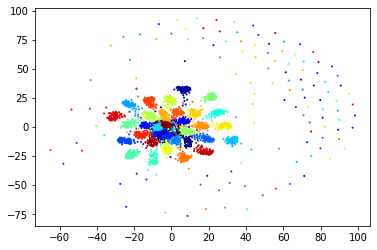

In [93]:
plt.scatter(X_norm_embedded[:,0],X_norm_embedded[:,1],s=1,c=Y.reshape(Y.size,),cmap='jet')
plt.show()

In [98]:
# randomly subsample the data to see if we still get seperation
n=1000
P = np.random.randint(0,X.shape[1],n)

In [101]:
X_norm_embedded_P = TSNE(n_components=2).fit_transform(X_norm[:,P])
print(X_norm_embedded_P.shape)

(3168, 2)


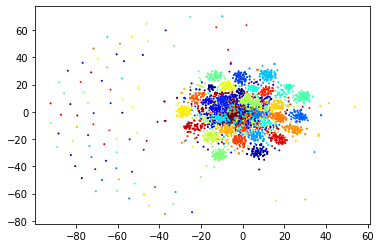

In [103]:
plt.scatter(X_norm_embedded_P[:,0],X_norm_embedded_P[:,1],s=1,c=Y.reshape(Y.size,),cmap='jet')
plt.show()

In [46]:
# Using only the neurons based on Random forest below. see 'selected_neurons'

X_norm_embedded_Select = TSNE(n_components=2).fit_transform(X_norm[:,selected_neurons])
print(X_norm_embedded_Select.shape)

(3168, 2)


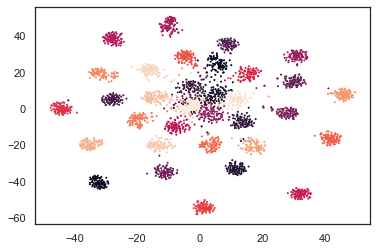

In [49]:
plt.scatter(X_norm_embedded_Select[:,0],X_norm_embedded_Select[:,1],s=1,c=Y.reshape(Y.size,))
plt.show()

It seems that only about ~250 neurons out of 11,000 is enough to understand which image the animals is looking at.

### UMAP

In [51]:
import umap

In [259]:
clf = umap.UMAP(n_components=2,n_neighbors=5)
embedding = clf.fit_transform(X_norm)
print(embedding.shape)

(3168, 2)


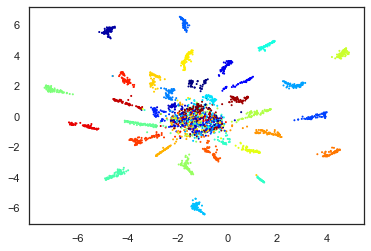

In [260]:
plt.scatter(embedding[:,0],embedding[:,1],s=1,c=Y.reshape(Y.size,),cmap='jet')
plt.show()

In [57]:
# Testing Selected neurons with UMAP too
clf = umap.UMAP(n_components=2,n_neighbors=15)
embedding_Select = clf.fit_transform(X_norm[:,selected_neurons])
print(embedding.shape)

(3168, 2)


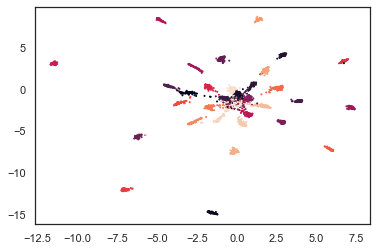

In [58]:
plt.scatter(embedding_Select[:,0],embedding_Select[:,1],s=1,c=Y.reshape(Y.size,))
plt.show()

### PCA

In [239]:
from sklearn.decomposition import PCA

In [240]:
X_norm_embedded = PCA(n_components=2).fit_transform(X_norm)
print(X_norm_embedded.shape)

(3168, 2)


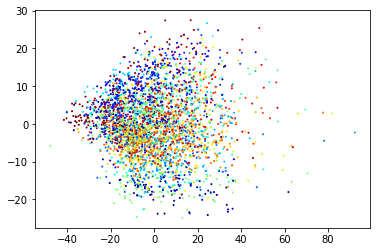

In [241]:
plt.scatter(X_norm_embedded[:,0],X_norm_embedded[:,1],s=1,c=Y.reshape(Y.size,),cmap='jet')
plt.show()

# Classification

In [27]:
# pre-processing
x_train = X_log[0:2500,:] # ~80%/20% training/test
x_test = X_log[2500:,:]
y_train = Y[0:2500]
y_test = Y[2500:]

x_train = x_train - np.mean(x_train,axis=0)
x_train = x_train / np.std(x_train,axis=0)

x_test = x_test - np.mean(x_test,axis=0)
x_test = x_test / np.std(x_test,axis=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2500, 11523)
(668, 11523)
(2500,)
(668,)


## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

In [185]:
y_pred = clf.predict(x_test)

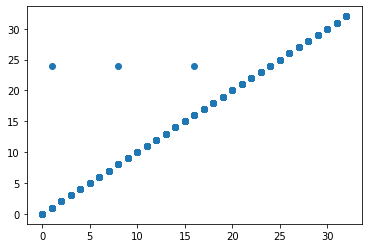

In [186]:
plt.scatter(y_test,y_pred)
plt.show()

In [182]:
performance = clf.score(x_test, y_test)
print(performance)

0.9955089820359282


## Support Vector Machine

In [30]:
from sklearn import svm

In [31]:
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
y_pred = clf.predict(x_test)

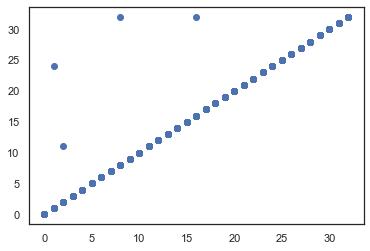

In [33]:
plt.scatter(y_test,y_pred)
plt.show()

In [34]:
clf.score(x_test,y_test)

0.9940119760479041

Performance of the support vector classifier is similar to logistic regression

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
#clf.fit(x_train, y_train)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

/Users/yonar/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


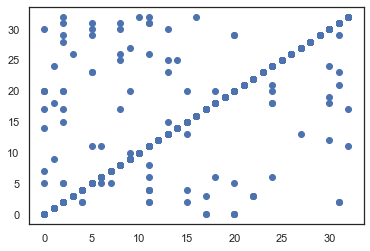

In [77]:
plt.scatter(y_test,y_pred)
plt.show()

In [78]:
print('performance: ', clf.score(x_test,y_test))

performance:  0.8592814371257484


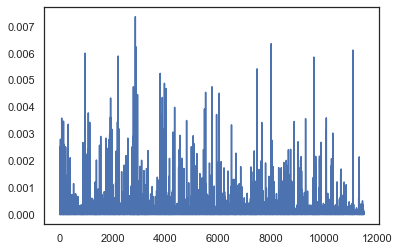

In [70]:
plt.plot(clf.feature_importances_)
plt.show()

In [71]:
selected_neurons = np.where(clf.feature_importances_>0.001)[0]
selected_neurons.shape

(246,)

Even though random forest performance is lower than other methods, Feature importance values suggest that encoding in the neurons in this study (V1 layer) is distributed but only 2% of the neurons is enough to classify images.

In [79]:
# Having only good features(neurons)
clf = RandomForestClassifier(max_depth=20, random_state=0)
#clf.fit(x_train, y_train)
clf.fit(x_train[:,selected_neurons], y_train)
y_pred = clf.predict(x_test[:,selected_neurons])
print('performance: ',clf.score(x_test[:,selected_neurons],y_test))

/Users/yonar/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


performance:  0.9041916167664671


Selected Features improve the performance from 85% to 90%. This suggest that other neurons introduce noise which makes it harder to to identify the object in front of the eye

## Feed-Forward Neural Network to Classify samples based on neural activity data

In [141]:
import keras
from keras.models import Model 
from keras.layers import Input, Dense, Lambda, Flatten
from keras import backend as K
from keras import optimizers
from keras.utils import to_categorical

In [137]:
#Pre-processing
print(X.shape)
print(X_log.shape)
print(X_norm.shape)
print(Y.shape)

(3168, 11523)
(3168, 11523)
(3168, 11523)
(3168, 1)


In [143]:
x_train = X_log[0:2500,:]
x_test = X_log[2500:,:]
y_train = Y[0:2500]
y_test = Y[2500:]

In [144]:
y_train = to_categorical(y_train,33)
y_test = to_categorical(y_test,33)

In [145]:
x_train = x_train - np.mean(x_train,axis=0)
x_train = x_train / np.std(x_train,axis=0)

x_test = x_test - np.mean(x_test,axis=0)
x_test = x_test / np.std(x_test,axis=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2500, 11523)
(668, 11523)
(2500, 33)
(668, 33)


In [166]:
#Build Neural Network Model
input_img = Input(shape=(np.prod(x_train.shape[1:]),))
#x = Dense(100, activation='relu', kernel_regularizer=regularizers.l1(0.01))(input_img)
#x = Dense(100, activation='relu', kernel_regularizer=regularizers.l1_on_each_neuron)(input_img)
x = Dense(100, activation='relu')(input_img)
x = Dense(100, activation='relu')(x)
output_class = Dense(y_train.shape[-1], activation='softmax')(x)

model = Model(input_img, output_class)

In [167]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11523)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1152400   
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 33)                3333      
Total params: 1,165,833
Trainable params: 1,165,833
Non-trainable params: 0
_________________________________________________________________


In [148]:
mysgd = optimizers.SGD(lr=0.03, momentum=0.0, decay=1e-4, nesterov=False)
#opt = optimizers.Adam(lr=0.001)
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
batch_size = 32
epochs = 10
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2500 samples, validate on 668 samples
Epoch 1/10
2500/2500 [==============================] - 2s 903us/step - loss: 0.7125 - accuracy: 0.8404 - val_loss: 0.0869 - val_accuracy: 0.9820
Epoch 2/10
2500/2500 [==============================] - 2s 762us/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0549 - val_accuracy: 0.9955
Epoch 3/10
2500/2500 [==============================] - 2s 760us/step - loss: 7.4322e-04 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9940
Epoch 4/10
2500/2500 [==============================] - 2s 744us/step - loss: 3.0042e-04 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.9955
Epoch 5/10
2500/2500 [==============================] - 2s 723us/step - loss: 1.8256e-04 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9955
Epoch 6/10
2500/2500 [==============================] - 2s 725us/step - loss: 1.3172e-04 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9955
Epoch 7/10
2500/2500 [==============================] - 2s 76

In [152]:
y_pred = model.predict(x_test)

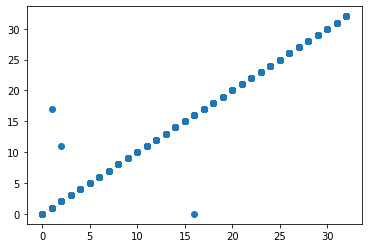

In [161]:
# All images except three are correctly predicted from neural activity with simple neural network model
y_pred_class = y_pred.argmax(axis=1)
y_test_class = y_test.argmax(axis=1)

plt.scatter(y_test_class,y_pred_class)
plt.show()
